In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /home/pj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/pj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Preprocessing
Integrating datasets into two data frames, True and False

In [2]:
df1 = pd.read_csv('Data/archive/Fake.csv')
df1['label'] = 'Fake'
del df1['subject']
del df1['date']

In [3]:
df2 = pd.read_csv('Data/archive/True.csv')
df2['label'] = 'True'
del df2['subject']
del df2['date']

In [4]:
df3 = pd.read_csv('Data/fake_or_real_news.csv')
del df3['Unnamed: 0']
df3['label'] = df3['label'].replace(['FAKE', 'REAL'], ['Fake', 'True'])

In [5]:
df4 = pd.read_csv('Data/fake.csv')
df4['label'] = 'Fake'
df4 = df4[['title', 'text', 'label']].copy()

In [6]:
frames = [df1, df2, df3, df4]
data = pd.concat(frames)
data.sample(20)

,title,text,label
22277,Boiler Room #92 – The (Hollywood) Hills Have Eyes,Tune in to the Alternate Current Radio Network...,Fake
13710,CHECK OUT ELIZABETH WARREN’S Rip On New BFF Hi...,Does anyone else see a little crazy in this wo...,Fake
4227,"Shooting Left 1 Dead, 5 Injured at Zodiac Park...","On November 1, 2016, at approximately 8:15 P.M...",Fake
1464,Michael Moore Owes Me $4.99,"28, 2016 | Reviews Michael Moore in New Yo...",Fake
6858,Kelly confirms he's been asked to be U.S. home...,(Reuters) - Retired Marine Corps General John ...,True
12325,Islamic State threatens U.S. attacks over Jeru...,CAIRO (Reuters) - Islamic State threatened att...,True
7025,Anonymous – World War 3 is imminent 2016,,Fake
9522,APOLOGY ISSUED After LA TIMES and NY TIMES Col...,Wow! What a couple of hypocrites and haters! W...,Fake
17614,"WATCH: ABUSIVE, TRUMP-HATING Student May Be Fa...","On September 27, 2017, an unhinged, liberal, T...",Fake
7465,"James Comey to be taken out, knows too much ab...","James Comey to be taken out, knows too much ab...",Fake


### Modified data quality report
Helps determine what further cleaning needs to be done

In [7]:
# Constructing a data quality report for the data
cat_data = {'Feature': ['title', 'text', 'label'],
            'Count': data.count(),
            '% Missing': data.isnull().sum() * 100 / len(data),
            'Cardinality': data.apply(pd.Series.nunique),
            'Mode': [data.mode()['title'][0], 'null', data.mode()['label'][0]],
            'Mode Freq.': ['14', '769', '39644'],
            'Mode %': [14 / 63552 * 100, 769 / 64186 * 100 , 39644 / 64232 * 100],
    
            'Notes': ['', '', '']}
cat_dqr_df = pd.DataFrame(cat_data)
cat_dqr_df.reset_index(drop=True, inplace=True)
cat_dqr_df

,Feature,Count,% Missing,Cardinality,Mode,Mode Freq.,Mode %,Notes
0,title,63552,1.058662,53541,Factbox: Trump fills top jobs for his administ...,14,0.022029,
1,text,64186,0.071615,54064,null,769,1.198081,
2,label,64232,0.000000,2,Fake,39644,61.720015,


In [8]:
data.drop_duplicates(inplace = True)

dfTrue = data[data['label'] == 'True']
dfFake = data[data['label'] == 'Fake']

dfFake.info()
dfTrue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30752 entries, 0 to 12998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   30122 non-null  object
 1   text    30706 non-null  object
 2   label   30752 non-null  object
dtypes: object(3)
memory usage: 961.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24351 entries, 0 to 6334
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   24351 non-null  object
 1   text    24351 non-null  object
 2   label   24351 non-null  object
dtypes: object(3)
memory usage: 761.0+ KB


In [9]:
# Train using 10% 
dfTrue = dfTrue.head(int(0.1 * dfTrue.shape[0]))
dfFake = dfFake.head(int(0.1 * dfFake.shape[0]))

### Data Cleaning
Removing stopwords, punctuation, and whitespace characters

In [10]:
def clean_string(input):
    stops = set(stopwords.words("english"))  # Set of stopwords

    input_tokenized = word_tokenize(input)   # Tokenize input
    input_without_sw = [word for word in input_tokenized if not word in stops]  # Remove stopwords
    input = (" ").join(input_without_sw)  # Combine back into sentence

    input = input.lower()
    input = re.sub('\n|\r|\t', '', input)   # Remove whitespace chars
    input = re.sub(r'[^\w\s]+', '', input)  # Remove punctuation
    
    
    return input

def preprocess(df):
    df.dropna(axis=0, inplace = True)  # Remove rows with missing values
    cleanfunc = np.vectorize(clean_string)    # Use vectorization to increase speed
    df['title'] = cleanfunc(df['title'])
    df['text'] = cleanfunc(df['text'])
    return df

In [11]:
dfTrue = preprocess(dfTrue)
dfFake = preprocess(dfFake)

### Feature Extraction & Visualization

#### Character Count in Title and Text

In [12]:
def getCharCount(df, field):
  return [len(text) for text in df[field].to_list()]


def histogram_char_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Characters")
  plt.ylabel("News")
  plt.title(f'Character Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_char_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Characters'])
  df.plot(x='News', y='Characters', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Characters', title=f'Average Character Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  

def character_stats(dfTrue, dfFake, field):
  print(f"Character Count Distribution of {field}")
  true_char_count= getCharCount(dfTrue, field)
  histogram_char_count(dfTrue, true_char_count, field, "True")

  fake_char_count = getCharCount(dfFake, field)
  histogram_char_count(dfFake, fake_char_count, field, "Fake") 

  print(f"Average Count of {field}")
  plot_avg_char_count(dfTrue, dfFake, field, true_char_count, fake_char_count)

Character Count Distribution of title


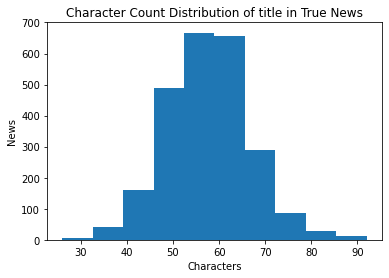

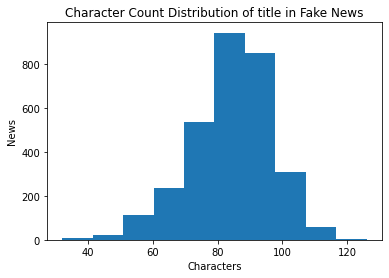

Average Count of title


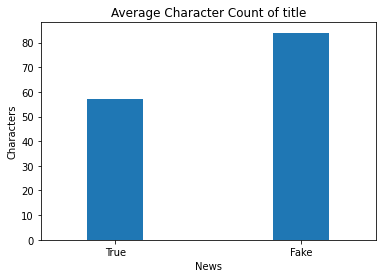

Character Count Distribution of text


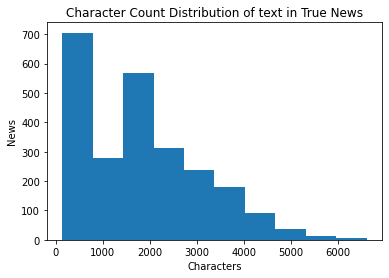

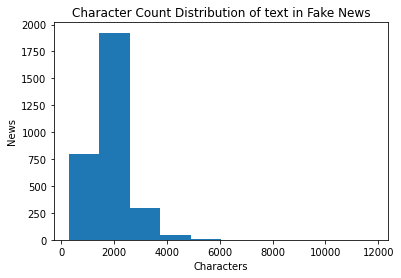

Average Count of text


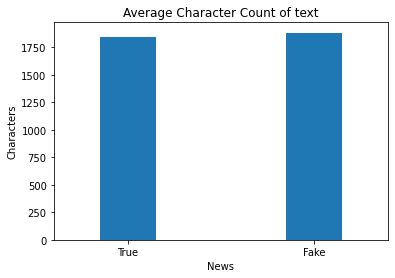

In [13]:
character_stats(dfTrue, dfFake, 'title')
character_stats(dfTrue, dfFake, 'text')

#### Word count in Title and Text

In [14]:
vectorizer = CountVectorizer()

def getWordCount(df, field):
  counts = []
  for text in df[field].to_list():
    text_count = np.sum(vectorizer.fit_transform([text]).toarray())
    counts.append(text_count)
  return counts

def histogram_word_count(df, count, field, label):
  plt.hist(count)
  plt.xlabel("Words")
  plt.ylabel("News")
  plt.title(f'Word Count Distribution of {field} in {label} News')
  plt.show()
  
def plot_avg_word_count(dfTrue, dfFake, field, countTrue, countFake):
  avg_count_true = int(np.average(countTrue))
  avg_count_fake = int(np.mean(countFake))

  df = pd.DataFrame([['True', int(avg_count_true)], ['Fake', int(avg_count_fake)]], columns=['News', 'Words'])
  df.plot(x='News', y='Words', kind='bar', width=0.3, xlabel='News', legend=False,
                    ylabel='Words', title=f'Average Word Count of {field}')  
  plt.xticks(rotation=0)
  plt.show()
  

def word_stats(dfTrue, dfFake, field):
  print(f"Word Count Distribution of {field}")
  true_word_count= getWordCount(dfTrue, field)
  histogram_word_count(dfTrue, true_word_count, field, "True")

  fake_word_count = getWordCount(dfFake, field)
  histogram_word_count(dfFake, fake_word_count, field, "Fake") 

  print(f"Average count of {field}")
  plot_avg_word_count(dfTrue, dfFake, field, true_word_count, fake_word_count)


Word Count Distribution of title


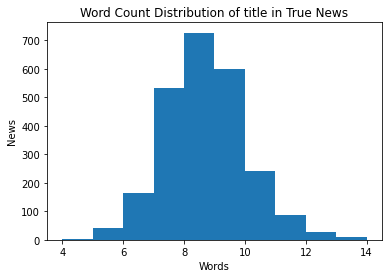

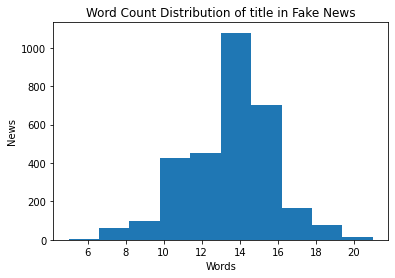

Average count of title


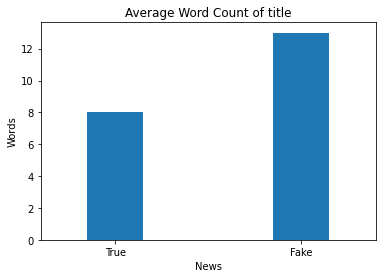

Word Count Distribution of text


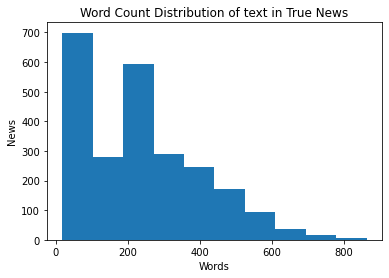

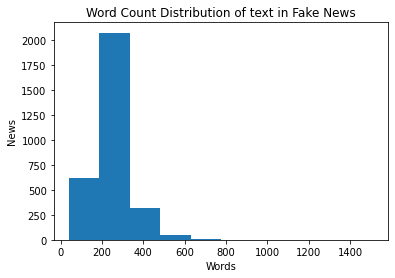

Average count of text


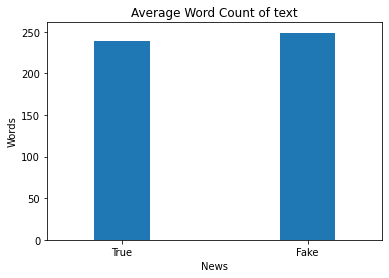

In [15]:
word_stats(dfTrue, dfFake, 'title')
word_stats(dfTrue, dfFake, 'text')

#### TF-IDF weights in Title and Text

In [16]:
def calc_tfidf(df, feature):
  tokenized = []
  for text in df[feature]:
    tokenized.append(word_tokenize(text))
  tfidf_vectorizer = TfidfVectorizer(input='content', stop_words='english')
  tfidf_vector = tfidf_vectorizer.fit_transform(df[feature]).toarray()

  for i in range(len(tokenized)):
    for j in range(len(tokenized[i])):
      word = tokenized[i][j]
      score = tfidf_vector[i][j]
      if score > 0.1:
        print(f"{tokenized[i][j]}: {tfidf_vector[i][j]}")

In [43]:
print("TF-IDF scores for Fake news titles\n")
calc_tfidf(dfFake, 'title')
print("TF-IDF scores for Fake news text\n")
calc_tfidf(dfFake, 'text')

TF-IDF scores for Fake news titles

capital: 0.33234594427419994
hairdoand: 0.348497182420216
bill: 0.4479665130609458
fore: 0.31605506706990133
president: 0.30932542324791096
images: 0.33551973664199736
bombed: 0.3941349990315388
however: 0.3319466305806722
something: 0.3584753387909431
least: 0.41260952240770843
being: 0.3946517057507165
https: 0.45829673812123756
eric: 0.4257521495546054
took: 0.4257521495546054
think: 0.3799283667786722
accused: 0.3355369004114664
2014: 0.3292190966521134
delete: 0.3340743778897251
earth: 0.4551780397112527
acts: 0.3952056355943579
donald: 0.4031985577785718
access: 0.4480603673672738
trump: 0.3933184917137466
suggestions: 0.3712901538110928
taken: 0.40234969598930587
gunman: 0.28086584247042085
back: 0.4099702634651166
surveys: 0.352328202422607
operator: 0.3667023403384926
tax: 0.3111789536582563
squads: 0.4247407712047714
dated: 0.46495959680822263
they: 0.3542844838674649
angerergetty: 0.38054444358589207
combination: 0.41318958976005693
novemb

In [18]:
print("\nTF-IDF scores for True news title\n")
calc_tfidf(dfTrue, 'title')
print("\nTF-IDF scores for True news text\n")
calc_tfidf(dfTrue, 'text')

TF-IDF scores for Fake news text

you: 0.3552043850220898
fbi: 0.12911816388280808
named: 0.13058337996997982
happy: 0.13485561651057804
added: 0.10323279989397369
former: 0.13367646796683588
november: 0.4250910744047068
brz: 0.20381440809094487
al: 0.304649271969679
media: 0.21667819956282408
state: 0.10518412719529838
sexual: 0.1762092172505422
working: 0.11513662841117653
david: 0.10834567113598209
i: 0.1277351847050348
informationfeatured: 0.13644583755882733
rate: 0.1987172982381308
room: 0.20030421310137642
done: 0.10541865131203254
that: 0.36583065916781876
goods: 0.10670150034121646
11: 0.2384004072309612
commented: 0.23038231200738452
become: 0.10888987776075369
252: 0.33624928155746514
people: 0.13011032702926073
inside: 0.11072942661344864
knee: 0.13552111913883835
trump: 0.47651311569802446
d: 0.2732621797340275
fault: 0.4401935203739771
romano: 0.24921547956709933
probably: 0.13047748519156577
available: 0.14938111663221793
bought: 0.19773400146691048
warpath: 0.1031826782

# Visualize keywords with WordCloud

In [74]:
def generateWordCloud(df, feature):
  wordcloud = WordCloud(max_words=30).generate(' '.join(df[feature].tolist()))
  
  # plot the WordCloud                      
  plt.figure(figsize = (10, 10), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  
  plt.show()


WordCloud for Fake News Titles


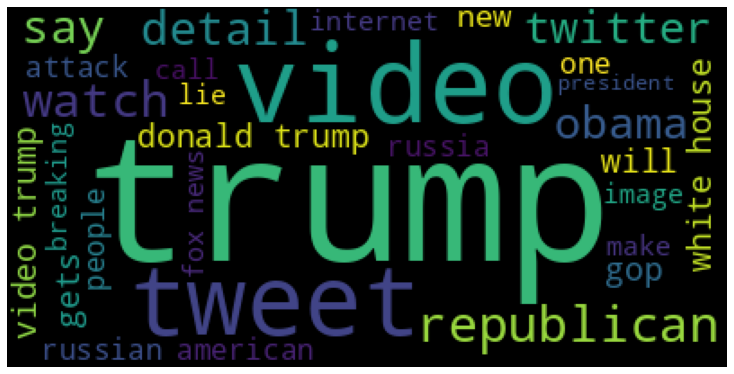

WordCloud for Fake News Text


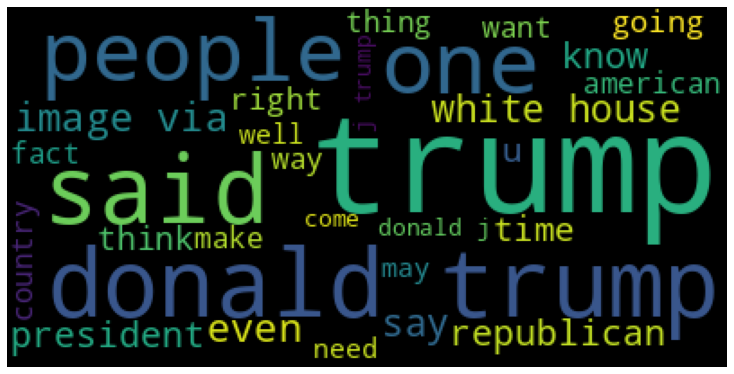

In [77]:
# Visualize most significant words for fake news
print("WordCloud for Fake News Titles")
generateWordCloud(dfFake, 'title')
print("WordCloud for Fake News Text")
generateWordCloud(dfFake, 'text')

WordCloud for True News Titles


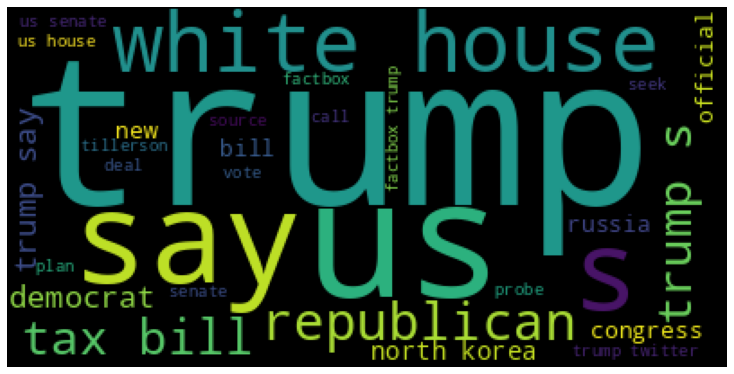

WordCloud for True News Text


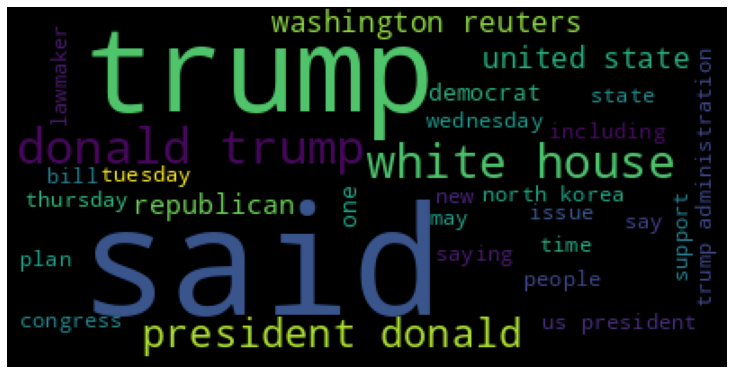

In [78]:
# Visualize most significant words for true news
print("WordCloud for True News Titles")
generateWordCloud(dfTrue, 'title')
print("WordCloud for True News Text")
generateWordCloud(dfTrue, 'text')